In [1]:
import struct
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
from itertools import islice  
import xgboost as xgb
from model_config import *
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from scipy import stats
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
#from treesbo.tuning import main_tuning_with_bo
%matplotlib inline
import matplotlib.pyplot as plt
import joblib


In [2]:
def lblrtm_tape11_reader(fname, opt):
    #%[波数，光学厚度]
    #% File format illustration
    #% for single precision
    #% shift 266*4 bytes
    #% LOOP
    #% 1 int        , 24 (block of v1, v2, dv, npts)
    #% 2 double vars, for v1, and v2
    #% 1 float      , for dv
    #% 1 int        , for npts
    #% 1 int        , 24
    #% 1 int        , 9600 or npts*4 (beg of block output)
    #% NPTs float   , rad
    #% 1 int        , 9600 or npts*4 (end of block of output)
    #% LOOP ENDS
    #
    #% for double precision
    #% shift 356*4 bytes
    #% LOOP
    #% 1 int        , 32 (v1, v2, dv and npts, extra 0)
    #% 3 double vars, for v1, v2, and dv
    #% 1 long int   , for npts
    #% 1 int        , 32   
    #% 1 int        , 19200 or npts*8 (beg of block of output)
    #% NPTS double  , rad
    #% 1 int        , 19200 or npts*8 (end of block of output)
    #% LOOP ENDS
    #%npts: the number of points in the panel?
    #% Author: Xianglei Huang
    #% Tested on Redhat Linux with pgi-compiler version of LBLRTM
    v = np.array([])
    rad = np.array([])
    if opt.lower() == 'float' or opt.lower() == 'single':
        shift = 266
        itype   = 1
    else:
        shift = 356
        itype = 2
    #print(shift,itype)
    fid = open(fname, 'rb')
    fid.seek(shift*4)
    #% decide whether need to open as big-endian file
    test = struct.unpack("i",fid.read(4))[0]  #matlab中的'int'对应c的'int'
    #print("test=",test)
    fid.close()
    if (itype == 1 and test == 24) or (itype ==2 and test == 32):
        fid = open(fname, 'rb')
        fid.seek(shift*4)
        order='<'
    else:
        fid = open(fname, 'rb')
        fid.seek(shift*4)
        order='>'        
    #print(order)
    endflg = 0
    panel = 0
#
    if itype == 1:   
        while endflg == 0:
            panel = panel + 1
            _ = struct.unpack(order+"i",fid.read(4))[0]
            v1= struct.unpack(order+"d",fid.read(8))[0]#matlab的'double'对应c的'double'，对应python的float，占8字节
            #print("v1=",v1)
            if np.isnan(v1):
                break
            v2= struct.unpack(order+"d",fid.read(8))[0]
            #print("v2=",v2)
            dv= struct.unpack(order+"f",fid.read(4))[0]#matlab的'float'对应c的'float'，对应python的float，占4字节
            #print("dv=",dv)
            npts= struct.unpack(order+"i",fid.read(4))[0]
            #print("npts=",npts)
            if npts!=2400:
                endflg=1
                #print("npts break"," and npts=",npts)
            _ = struct.unpack(order+"i",fid.read(4))[0]
            LEN= struct.unpack(order+"i",fid.read(4))[0]
            if LEN!=4*npts:
                #print('1 internal file inconsistency')
                endflg=1
            tmp= struct.unpack(order+str(npts)+"f",fid.read(4*npts))
            #print("tmp=",tmp)
            LEN2= struct.unpack(order+"i",fid.read(4))[0]
            if LEN != LEN2:
                #print('2 internal file inconsistency')
                endflg=1
            v=np.append(v,np.arange(v1,v2,dv).transpose())
            rad=np.append(rad,np.array(tmp).reshape(npts,1))
    else:
        print("itype != 1")
        while endflg == 0:
            panel = panel + 1
            _ = struct.unpack(order+"i",fid.read(4))[0]
            tmp= struct.unpack(order+"3d",fid.read(8*3))
            v1=tmp[0]
            v2=tmp[1]
            dv=tmp[2]
            if np.isnan(v1):
                break 
            npts= struct.unpack(order+"q",fid.read(8))[0] #npts = fread(fid, 1, 'int64');
            if npts!=2400:
                endflg=1
                #print("npts break")
            _ = struct.unpack(order+"i",fid.read(4))[0]   
            LEN= struct.unpack(order+"i",fid.read(4))[0]
            if LEN!=8*npts:
                #print('3 internal file inconsistency')
                endflg=1
            tmp= struct.unpack((order+str(npts)+"d"),fid.read(8*npts))
            LEN2= struct.unpack(order+"i",fid.read(4))[0]
            if LEN != LEN2:
                #print('4 internal file inconsistency')
                endflg=1
            v=np.append(v,np.arange(v1,v2,dv).transpose())
            rad=np.append(rad,np.array(tmp).reshape(npts,1))                
    fid.close()
    return v,rad

In [3]:
def EC(fname):
    p=np.array([])
    t=np.array([])
    wv=np.array([])
    co2=np.array([])
    o3=np.array([])
    no2=np.array([])
    co=np.array([])
    ch4=np.array([])
    input_file=open(fname)
    num=0
    for line in islice(input_file,19,None):
        num=num+1
        #print(line)
        p_temp,t_temp,wv_temp,co2_temp,o3_temp,no2_temp,co_temp,ch4_temp=[float(i) for i in line.split()]
        p=np.append(p,p_temp)
        t=np.append(t,t_temp)
        wv=np.append(wv,wv_temp)
        co2=np.append(co2,co2_temp)
        o3=np.append(o3,o3_temp)
        no2=np.append(no2,no2_temp)
        co=np.append(co,co_temp)
        ch4=np.append(ch4,ch4_temp)
        if num%101==0:
            for line2 in islice(input_file, 0, 2):
                continue
            
    return p,t,wv,co2,o3,no2,co,ch4

In [4]:
def func_evaluation(y_real, y_pred, verbose=True):
    """
    y_real: real values
    y_pred: prediction values
    MAKE THEM HAVE THE SHAPE OF (N,) FIRST BY USING ndarray.ravel()
    """
    if not isinstance(y_real, np.ndarray):
        y_real = np.array(y_real)
    if not isinstance(y_pred, np.ndarray):
        y_pred = np.array(y_pred)
    y_real = y_real.ravel()
    y_pred = y_pred.ravel()

    # MAPE
    def cal_mape(y_true, y_pred):
        y_true = np.where(y_true == 0, 1, y_true)  # To avoid zeros.
        mape = np.mean(abs((y_true.ravel() - y_pred.ravel()) / y_true.ravel()))
        return mape

    m0 = stats.pearsonr(y_real, y_pred)[0]
    m1 = r2_score(y_real, y_pred)
    m2 = explained_variance_score(y_real, y_pred)
    m3 = mean_squared_error(y_real, y_pred)
    m4 = mean_absolute_error(y_real, y_pred)
    m5 = cal_mape(y_real, y_pred)
    if verbose:
        print("模型的评估结果:")
        print(
            'PersonR: %f \nRMSE: %f \nR2: %f \nExplained Variance: %f \nMSE: %f \nMAE: %f \nMAPE: %f'
            % (m0, np.sqrt(m3), m1, m2, m3, m4, m5))
    return m0, np.sqrt(m3), m1, m2, m3, m4, m5



In [5]:
ecpath='/mnt/FY4_GIIRS_OD'
ozopath='/mnt/FY4_GIIRS_OD/ozo/angle1'
ec_name=ecpath+'/ECMWF_83P_101L.dat'
#print(type(test_name))
p,t,wv,co2,o3,no2,co,ch4=EC(ec_name)   
#print(t)
ec_input=np.hstack((p.reshape(-1,1),t.reshape(-1,1),wv.reshape(-1,1),co2.reshape(-1,1),o3.reshape(-1,1),no2.reshape(-1,1),co.reshape(-1,1),ch4.reshape(-1,1)))
print(ec_input.shape)
ec_input_100=np.zeros((83*100,ec_input.shape[1]))
for pro in range(0,83): #83条
    for i in range(0+101*pro,100+101*pro):
        for j in range(ec_input.shape[1]):
            ec_input_100[i-101*pro+100*pro,j]=(ec_input[i,j]+ec_input[i+1,j])/2.0
print(ec_input_100.shape)

(8383, 8)
(8300, 8)


In [6]:
#把EC83的廓线按照第一条，第一层复制55万个，然后第二条、第一层，共83*100*55万个数据。
ec_df=pd.DataFrame(ec_input_100)
#print(ec_df)

true_total=np.array([])
pre_total=np.array([])
for i in range(1,0,-1):
#for i in range(99,-1,-1):
    f = open("metrics_%d.txt" %(i), "w")
    tot=np.array([])
    v=np.array([])
    chara1=np.array([])
    chara2=np.array([])
    mg_od=np.array([])
    for pro in range(0,83):
     #倒叙原因是为与ozo文件统一，ozo中第一层是最底层
    
        new=np.repeat(ec_df.iloc[i+pro*100].values.reshape(1,-1),555001,axis=0)
        lev=100-i
        ######开始读取特征向量,对应的是每一层，每一条廓线###########
        if pro==82:
            chara1_temp=pd.read_csv('./chara/chara1_%dP_%03d.csv'%(pro+1,lev))['0'].values
            chara2_temp=pd.read_csv('./chara/chara2_%dP_%03d.csv'%(pro+1,lev))['0'].values
            print("82 mean profile")
        #print(chara1_temp.shape)
        
        tot=np.append(tot,new)
        
        #####开始处理ozo的小文件
        fix_name = glob.glob(ozopath+'/*_%dP_*%03d' %(pro+1,lev))
        if os.path.exists(fix_name[0]):
            v_temp,mg_od_temp = lblrtm_tape11_reader(fix_name[0],'single')
            mg_od_temp=np.exp(-mg_od_temp)
            #print("小文件测试",v_temp.shape,mg_od_temp.shape)
            #print(np.where(mg_od_temp==np.max(mg_od_temp)))
            #print(v_temp[22515])
            #fig = plt.figure(figsize=(15,10))
            #ax1 = fig.add_subplot(211)         
            #l1,=ax1.plot(v_temp,mg_od_temp,'g-',linewidth=1.5)
            #ax2 = fig.add_subplot(212)
            #l2,=ax2.plot(mg_od_temp,'r:', linewidth=1.5)
            #plt.show()            
        else:
            v_temp=np.full([555001,], np.nan)
            mg_od_temp=np.full([555001,], np.nan)
        v=np.append(v,v_temp)
        mg_od=np.append(mg_od,mg_od_temp)
        if pro==82:
            chara1=np.append(chara1,chara1_temp)
            chara2=np.append(chara2,chara2_temp)
    tot=tot.reshape(-1,8)
    v=v.reshape(-1,1)
    chara1=chara1.reshape(-1,1) #应该是有555001个
    chara1_in=np.repeat(chara1,83,axis=0)
    print(chara1_in.shape)
    chara2=chara2.reshape(-1,1)
    chara2_in=np.repeat(chara2,83,axis=0)
    mg_od=mg_od.reshape(-1,1)
    #print(tot.shape)
    X=np.hstack((tot,v,chara1_in,chara2_in))
    print(X.shape)
    #print(X)
    Y=mg_od
    print(Y.shape)
    print(datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
    f.write("start："+datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')+"\n")
    #########开始训练并比较结果
    print("####################！！！LGB Running！！！##########################")
    #best_params, loss=main_tuning_with_bo(
    #X_train=X[:60*555001],
    #y_train=Y[:60*555001].ravel(),
    #X_val=X[60*555001:],
    #y_val=Y[60*555001:].ravel(),
    #model_nm='LGB',
    #max_evals=3,
    #folds=None,
    #nfold=3,
    #eval_metric='l1',
    #task='regression')
    #print(best_params,loss)
    model2 = lgb.LGBMRegressor(**lgbm_params)
    model2.fit(X[:60*555001], Y[:60*555001].ravel())
    #model2 = lgb.LGBMRegressor()
    #gs2 = GridSearchCV(model2, lgbm_grid, cv=3, n_jobs=-1)
    #gs2.fit(X[:60*555001], Y[:60*555001].ravel())
    #print(gs2.best_params_)
    #print(gs2.best_score_)
    #best_model2=gs2.best_estimator_
    y_pred2 = model2.predict(X[60*555001:])
    metrics_i2 = func_evaluation(Y[60*555001:], y_pred2)
    f.write("LGB_finished:"+datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')+"\n")
    f.write(str(lgbm_params))
    f.write(str(metrics_i2)+"\n")
    joblib.dump(model2, 'model_level_%02d.pkl' %(i))
    print("LGB",metrics_i2)
    
    true_total=np.append(true_total,Y[60*555001:])
    pre_total=np.append(pre_total, y_pred2)
    #fig = plt.figure(figsize=(15,10))
    #ax1 = fig.add_subplot(211)         
    #l1,=ax1.plot(X[60*555001:],Y[60*555001:],'g-',linewidth=1.5)
    #l2,=ax1.plot(X[60*555001:],y_pred2,'r:',linewidth=1.5)
    #plt.savefig("OD_plot.png",dpi=100)
    #plt.show()
    

    #print("####################！！！RF Running！！！##########################")
    #best_params3, loss3=main_tuning_with_bo(
    #X[:60*555001],
    #Y[:60*555001].ravel(),
    #model_nm='RF',
    #max_evals=10,
    #folds=None,
    #nfold=3,
    #eval_metric='l2',
    #task='regression')
    #print(best_params3,loss3)
    #model3 = RandomForestRegressor(**best_params3)
    #model3.fit(X[:60*555001], Y[:60*555001].ravel()) 
    #y_pred3 = model3.predict(X[60*555001:])
    #metrics_i3 = func_evaluation(Y[60*555001:], y_pred3)
    #f.write("RF_finished:"+datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')+"\n")
    #f.write(str(best_params3))
    #f.write(str(metrics_i3)+"\n")
    #print("RF",metrics_i3)
    
#
    #print("####################！！！ET Running！！！##########################")
    #model4 = ExtraTreesRegressor(**et_params)
    #model4.fit(X[:60*555001], Y[:60*555001].ravel())
    #y_pred4 = model4.predict(X[60*555001:])
    #metrics_i4 = func_evaluation(Y[60*555001:], y_pred4)
    #f.write(str(datetime.datetime.now())+str(metrics_i4)+"\n")
    #print("ET",metrics_i4) 
    #
#
    #print("####################！！！CAT Running！！！##########################")
    #model5 = CatBoostRegressor(**cat_params,verbose=None)
    #model5.fit(X[:60*555001], Y[:60*555001].ravel())
    #y_pred5 = model5.predict(X[60*555001:])
    #metrics_i5 = func_evaluation(Y[60*555001:], y_pred5)
    #f.write(str(datetime.datetime.now())+str(metrics_i5)+"\n")
    #f.write("end"+datetime.datetime.now()+"\n")
    #print("CAT",metrics_i5) 
    #
#
    #print("####################！！！XGBoost Running！！！##########################")
    #model = xgb.XGBRegressor(**xgb_params)
    #model.fit(X[:60*555001], Y[:60*555001].ravel()) ###共83条廓线，前80条做训练，后3条做测试
    #y_pred = model.predict(X[60*555001:])
    #metrics_i = func_evaluation(Y[60*555001:], y_pred)
    #f.write(str(datetime.datetime.now())+str(metrics_i)+"\n")
    #print("XGB:",metrics_i)
    f.close()
#    if i==99:
#        break



82 mean profile
(46065083, 1)
(46065083, 11)
(46065083, 1)
2021-04-28 08:42:46
####################！！！LGB Running！！！##########################
模型的评估结果:
PersonR: 0.149204 
RMSE: 0.014771 
R2: 0.022260 
Explained Variance: 0.022260 
MSE: 0.000218 
MAE: 0.000660 
MAPE: 35662797335127621632.000000
LGB (0.14920359206263822, 0.014770614567921699, 0.02226049569364741, 0.02226049661189866, 0.0002181710547141007, 0.0006598929351656624, 3.566279733512762e+19)


In [7]:
np.savez('pre_99pro.npz', sequence_array=pre_total)
np.savez('tru_99pro.npz', sequence_array=true_total)
metrics_total = func_evaluation(true_total, pre_total)
print(metrics_total)

模型的评估结果:
PersonR: 0.149204 
RMSE: 0.014771 
R2: 0.022260 
Explained Variance: 0.022260 
MSE: 0.000218 
MAE: 0.000660 
MAPE: 35662797335127621632.000000
(0.14920359206263822, 0.014770614567921699, 0.02226049569364741, 0.02226049661189866, 0.0002181710547141007, 0.0006598929351656624, 3.566279733512762e+19)


(1263737277,) (1263737277,)
0.024395189605439443


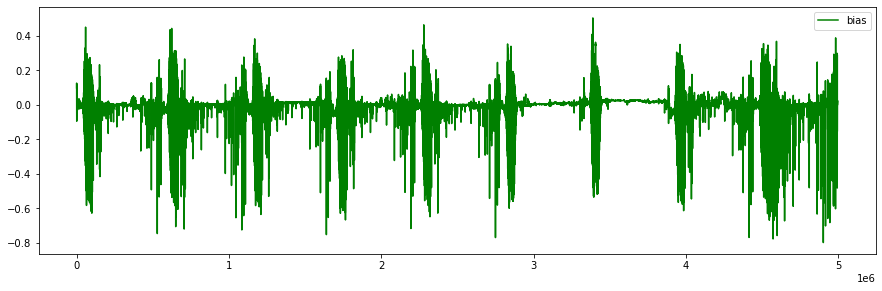

In [8]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)  
print(true_total.shape,pre_total.shape)
print(np.mean(abs(true_total.ravel()-pre_total.ravel())))
l1,=ax1.plot(true_total[190*555001:199*555001].ravel()-pre_total[190*555001:199*555001].ravel(),'g-',linewidth=1.5)
plt.legend(["bias"])
#plt.savefig("OD_plot.png",dpi=100)
plt.show()

(1263737277,)


In [ ]:
#取出第一层的数据，即前（55万个*83条）条数据

In [ ]:
##fixpath='/home/liuli/liul/fixgas/angle1'
#
##ßwvpath='/home/liuli/liul/wv/angle1'
#
#for lev in range(1,2):#101):
##    print(pro)  
#    for pro in range(1,2): #84):
#        fix_name = glob.glob(ozopath+'/*_%dP_*%03d' %(pro,lev))
#        if os.path.exists(fix_name[0]):
#            print(fix_name[0])
#            v_temp,mg_od_temp = lblrtm_tape11_reader(fix_name[0],'single')
#            
#        else:
#            v=np.full([555001,], np.nan)
#            mg_od=np.full([555001,], np.nan)
#        v=np.append(v,v_temp)
#        #print(v.shape)
#        mg_od=np.append(mg_od,mg_od_temp)
#print(v.shape,mg_od.shape)
##np.savez('v.npz', sequence_array=v)
##np.savez('mg_od.npz', sequence_array=mg_od)